# Utilities

In [6]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

from abc import ABC, abstractmethod
import collections

In [ ]:
savefig = False # Indicate if we want to save the figures

In [84]:
class TranslocationModel(ABC):
    """A translocation model defined by a kinetic scheme.
    
    The kinetic scheme is a directed graph where the nodes are the states of
    the system and the edges are the reactions. The nodes have a 'probability'
    attribute, which is the probability of the steady-state system to be in
    this state. The directed edges have a 'rate' attribute, which is the rate
    of the reaction. 

    The translocation model is a stochastic process. It can be simulated using
    the Gillespie algorithm. The stochastic process is a single particle
    evoluting on the kinetic scheme. 

    We a re interested in the position of the particle over time, for various
    models such as 'Sequential Clockwise/2-Residue Step' or 'Disc-Spiral'.

    TODO 
    displacement: The number of residues the particle translocated.
        Can be positive or negative if the translocation goes forward or
        backward.
    About the ATP/ADP consumption/exchange:
    ATP_consumption: How many ATP are consumed.
    ATP_synthesis: How many ATP are synthesized.

    Let states have probability weights that is a function, and add a method
    that compute the (steady-state) probability of a given state.

    Pass a dictionnary of all constants/rates/etc to the constructor, and 
    nodes and edges attributes are then functions that take this dict in 
    parameter and the body of the function is the formula to compute the
    rate/probability/etc.
    Give example (like first construct object, then update parameter dict, etc)
    Parameters already has the following: (commun to all models)
    """

    def __init__(self, ATP_ADP_ratio: float = 10,): 
        # TODO think about what we want to define, think about the units
        # Only ratios is enough? Or do we want to define the rates directly?
        self._equilibrium_ATP_ADP_ratio = 1
        self._ATP_ADP_ratio = ATP_ADP_ratio
        # Association/dissociation protomer-ATP/ADP rates
        self._k_on_ATP = 1
        self._k_off_ATP = 1
        self._k_on_ADP = 1
        self._k_off_ADP = 1
        # ATP hydrolysis/synthesis rates
        self._k_h = 1
        self._k_s = 1
        
        self.kinetic_scheme = None # TODO abstract attribute
        
    @property
    def equilibrium_ATP_ADP_ratio(self) -> float:
        """ATP/ADP concentrations ratio at equilibrium.""" 
        return self._equilibrium_ATP_ADP_ratio
    
    @property
    def ATP_ADP_ratio(self) -> float:
        """ATP/ADP concentrations ratio."""
        return self._ATP_ADP_ratio
    
    @ATP_ADP_ratio.setter
    def ATP_ADP_ratio(self, value: float) -> None:
        if value < 0:
            raise ValueError("The ATP/ADP ratio must be nonnegative.")
        self._ATP_ADP_ratio = value
    
    @property
    def k_on_ATP(self) -> float: 
        """Protomer-ATP association rate."""
        return self._k_on_ATP

    @property
    def k_off_ATP(self) -> float: 
        """Protomer-ATP dissociation rate."""
        return self._k_off_ATP

    @property
    def k_on_ADP(self) -> float: 
        """Protomer-ADP association rate."""
        return self._k_on_ADP

    @property
    def k_off_ADP(self) -> float: 
        """Protomer-ADP dissociation rate."""""
        return self._k_off_ADP
    
    @property
    def k_h(self) -> float: 
        """ATP hydrolysis rate."""
        return self._k_h

    @property
    def k_s(self) -> float: 
        """ATP synthesis rate."""
        return self._k_s

    @property
    def K_d_ATP(self) -> float: 
        """Protomer-ATP dissociation constant."""
        return self.k_off_ATP / self.k_on_ATP

    @property
    def K_d_ADP(self) -> float: 
        """Protomer-ATP dissociation constants"""
        return self.k_off_ADP / self.k_on_ADP

    @abstractmethod # TODO @override in subclasses
    def _construct_kinetic_scheme(
        self, 
        kinetic_scheme: nx.DiGraph | None = None
    ) -> nx.DiGraph:
        """Construct the kinetic scheme of the translocation model.
        # TODO comment
        """
        pass
    
    def gillespie(
        self, 
        n_steps: int = 1000, 
        initial_state: None | str = None,
        n_simulations: int = 1,
        cumulative_sums: dict[str, str] | None = None,
    ) -> pd.DataFrame | list[pd.DataFrame]:
        """Simulate the stochastic system using the Gillespie algorithm.

        Simulate the stochastic evolution of a single particle evoluting on 
        the kinetic scheme using the Gillespie algorithm.

        Args:
            n_steps: The number of simulation steps.
            initial_state: The initial state of the system. If None, a random
                initial state is chosen.
            n_simulations: The number of simulations to do. If > 1, the returned
                object is a list of dataframes, one for each simulation.
            cumulative_sums: Dictionary of form 'column_name': 'edge_attribute'.
                Each simulation result dataframe then contains new columns 
                named 'column_name' with the cumulative sum of the specified 
                edge attributes at each step, with the timestamp. It adds a
                row at the beginning with timestamp 0 and 0 value at each
                column. 
                If None, each simulation returns a dataframe with the timestamp 
                and the edge taken at each step with all its attributes.

        Returns:
            A dataframe (or a list of dataframes if n_simulations > 1) with the
            columns 'timestamp', 'edge' and the keys of 
            cumulative_sums. The 'edge' column contains tuples of
            the form (state_from, state_to, attributes), where attributes is a
            dict of the form 'attribute': value.
        """
        if n_steps < 1:
            raise ValueError(
                "The number of steps must be strictly greater than 0.")
        if initial_state and initial_state not in self.kinetic_scheme.nodes():
            raise ValueError("The initial state does not belong to the graph.")
        if n_simulations < 1:
            raise ValueError(
                "The number of simulations must be strictly greater than 0.")

        results = []
        for _ in range(n_simulations):
            result = {'timestamp': [], 'edge': []}

            time = 0
            state = (initial_state if initial_state 
                     else np.random.choice(list(self.kinetic_scheme.nodes())))
            for _ in range(n_steps):
                # Each step the system starts in the current state and then 
                # after a sojourn time given by an exponential distribution
                # with parameter the sum of the leaving rates of the current 
                # state, it goes to the next state chosen with probability 
                # proportional to the leaving rates.
                out_edges = list(
                    self.kinetic_scheme.out_edges(state, data=True))
                total_rate = sum(
                    [attributes['rate'] for _, _, attributes in out_edges])
                sojourn_time = np.random.exponential(1/total_rate)
                chosen_edge_i = np.random.choice(
                    list(range(len(out_edges))), 
                    p=[attributes['rate']/total_rate 
                       for _, _, attributes in out_edges])
                chosen_edge = out_edges[chosen_edge_i]
                
                time += sojourn_time
                state = chosen_edge[1]

                result['timestamp'].append(time)
                result['edge'].append(chosen_edge)
            result = pd.DataFrame(result)
            if cumulative_sums:
                self._compute_cumulative_sums(result, cumulative_sums)
            results.append(result)

        if n_simulations == 1:
            out = results[0]
        else:
            out = results

        return out
    
    def _compute_cumulative_sums(
        self,
        result: pd.DataFrame,
        cumulative_sums: dict[str, str],
    ) -> None:
        """Compute the cumulative sum of the specified edge attributes.

        The post-processing consists in computing the cumulative sum of the
        specified edge attributes at each step. 
        The result is updated in-place.

        Args:
            result: A dataframe with the columns 'timestamp' and 'edge'. The
                'edge' column contains tuples of the form 
                (state_from, state_to, attributes), where attributes is a dict
                of the form 'attribute': value.
            cumulative_sums: Dictionary of form 'column_name': 'edge_attribute' 
                for what attributes to do the cumulative sum.
        """
        for column_name, edge_attribute in cumulative_sums.items():
            result[column_name] = (
                result['edge']
                .apply(lambda edge: edge[2].get(edge_attribute))
                .cumsum())
        # Add a row at the beginning with timestamp 0 and value 0 at each column
        result.loc[-1] = [0] + [None] + [0] * len(cumulative_sums)
        result.index += 1
        result.sort_index(inplace=True)
    
    def plot_position_evolution(
        self, 
        trajectory: pd.DataFrame | list[pd.DataFrame],
        time_unit: str, 
        position_unit: str = "#Residues", 
        kinetic_scheme_image_path: str | None = None, 
        ax: mpl.axes.Axes | None = None,
        title: str | None = None,
    ) -> (mpl.axes.Axes | tuple[mpl.figure.Figure, mpl.axes.Axes]):
        """Plot the evolution of the position.

        Plot the position going at the average velocity as well.

        Args:
            trajectory: Position and timestamp at every changement of the 
                position (in residues, not steps). It must have these two
                columns: 'timestamp' and 'position'. It can also be a list of
                dataframes, one for each simulation. In this case, every 
                trajectory is plotted on the same axes.
            time_unit: Unit of the time (x-)axis
            position_unit: Unit of the position (y-)axis
            kinetic_scheme_image_path: If given, will add the image of the
                kinetic scheme on the plot.
            ax: The axes where to plot. If None, a new axes is created.
            title: The title of the plot. If None, no title is added.

        Returns:
            The axes with the plot.
        """

        if not ax:
            _, ax = plt.subplots(figsize=(6, 6))
        
        # Single or multiple trajectories handled the same way in an iterable
        trajectories = (trajectory 
                        if isinstance(trajectory, collections.Iterable) 
                        else [trajectory])
        for trajectory in trajectories:
            ax.step(trajectory["timestamp"], trajectory["position"], where="post", 
                    label="From Gillespie algorithm")
        ax.plot(trajectories[0]["timestamp"], 
                trajectories[0]["timestamp"] * self.average_velocity(), 
                label="From average velocity")
        ax.set_xlabel("Time" + " [" + time_unit + "]")
        ax.set_ylabel("Position" + " [" + position_unit + "]")
        ax.legend() # TODO only one color for all trajectories
        if kinetic_scheme_image_path:
            img = np.asarray(Image.open(kinetic_scheme_image_path))
            sub_ax = ax.inset_axes([0.55, 0., 0.44, 0.44])
            sub_ax.imshow(img)
            sub_ax.axis('off')

        if title:
            ax.set_title(title)

        return ax
    
    def average_velocity(self) -> float:
        """Return the average velocity of the translocation model.

        The average velocity is computed analytically from the kinetic scheme
        using formula: 
            v = (p_lower * rate_up - p_upper * rate_down) * residues_per_step
        The unit depends on the unit of the rates.

        # TODO return also the unit
        """
        v = (
            self.kinetic_scheme.nodes[self.transition_up[0]]['probability'] # p_lower
            * self.kinetic_scheme.edges[self.transition_up]['rate'] # rate_up
            - self.kinetic_scheme.nodes[self.transition_up[1]]['probability'] # p_upper
            * self.kinetic_scheme.edges[self.transition_up[::-1]]['rate'] # rate_down
        ) * self.n_residues_per_step
        return v
    
    def ATP_consumption_rate(self, ):# list of edges that consume ATP TODO
        pass
    
    def normalize_average_velocity(self, inplace: bool = False
    ) -> nx.DiGraph | None:
        """Normalize the average velocity of the translocation model.

        Can be used to compare different models.
        When the velocity is normalized, the units # TODO -> set an edge as reference rate maybe, or a rate
        """

        if self.average_velocity() == 0:
            raise ValueError("The average velocity is null, cannot normalize.")
        
        average_velocity = self.average_velocity() # Velocity before normalization
        kinetic_scheme = (self.kinetic_scheme if inplace 
                          else self.kinetic_scheme.copy())
        for edge in kinetic_scheme.edges():
            kinetic_scheme.edges[edge]['rate'] /= average_velocity
        # TODO update time unit
        return kinetic_scheme
    
    def update_ATP_ADP_ratio(self, ATP_over_ADP: float) -> None: # Change name from ATP_over_ADP to ATP_ADP_ratio everywhere
        """Update the ATP/ADP ratio.

        This affects the rates k_DT and k_TD.
        """

        if ATP_over_ADP < 0:
            raise ValueError("The ATP/ADP ratio must be nonnegative.")
        
        kinetic_scheme = self.kinetic_scheme.copy()
        for edge in kinetic_scheme.edges():
            if edge[0] == "DTT":
                kinetic_scheme.edges[edge]['rate'] *= ATP_over_ADP
            elif edge[0] == "TTD":
                kinetic_scheme.edges[edge]['rate'] /= ATP_over_ADP
        return kinetic_scheme
    
    def get_time_unit(self) -> str: # TODO verify 
        """Return the unit of time of the model."""
        pass

        

# Models

In [85]:
class SequentialClockwise2ResidueStep(TranslocationModel):
    """Sequential Clockwise/2-Residue Step."""

    def __init__(self, ATP_ADP_ratio: float = 10) -> None:
        super().__init__(ATP_ADP_ratio)

        self._k_DT = 1 # Effective ADP->ATP exchange rate
        self._k_up = 1 # Translocation up rate
    
    @property
    def k_DT(self) -> float: 
        """Effective ADP->ATP exchange rate."""
        return self._k_DT
    
    @property
    def k_TD(self) -> float:
        """Effective ATP->ADP exchange rate.
        
        It is constrained by the ATP/ADP exchange model.
        """
        return (
            self.k_DT
            * self.K_d_ATP
            / self.K_d_ADP
            / self.equilibrium_ATP_ADP_ratio
        )
    
    @property
    def k_up(self) -> float: 
        """Translocation up rate."""
        return self._k_up
    
    @property
    def k_down(self) -> float:
        """Translocation down rate.
        
        It is constrained by the thermodynamics of the kinetic scheme.
        """
        return (
            self.k_h
            * self.k_up
            * self.k_DT
            / (self.k_s * self.k_TD)
            * self.equilibrium_ATP_ADP_ratio
            / self.ATP_ADP_ratio
        )


class SC2R1Loop(SequentialClockwise2ResidueStep):
    """Sequential Clockwise/2-Residue Step, 1-Loop translocation model.
    
    # TODO dire quelles sont les contraintes (exhange model + 1 thermodynamic loop)
    # TODO donner default time unit, ou maybe pas et dire 1/k de façon générale
    # TODO commenter
    """

    def __init__(self, ATP_ADP_ratio: float = 10) -> None:
        super().__init__(ATP_ADP_ratio)

        self._k_DT = 1 # Effective ADP->ATP exchange rate
        self._k_up = 1 # Translocation up rate

        self.kinetic_scheme = self._construct_kinetic_scheme()

    @property
    def p_TTT(self) -> float:
        """Steady-state probability to be in TTT state."""
        return self._TTT_probability_weight / self._normalizing_factor
    
    @property
    def p_DTT(self) -> float:
        """Steady-state probability to be in DTT state."""
        return self._DTT_probability_weight / self._normalizing_factor
    
    @property
    def p_TTD(self) -> float:
        """Steady-state probability to be in TTD state."""
        return self._TTD_probability_weight / self._normalizing_factor
    
    @property
    def _TTT_probability_weight(self) -> float:
        """Steady-state probability weight of TTT state."""
        return (
            self.k_s * self.k_DT
            + self.k_s * self.k_down
            + self.k_up * self.k_DT
        )
    
    @property
    def _DTT_probability_weight(self) -> float:
        """Steady-state probability weight of DTT state."""
        return (
            self.k_h * self.k_down
            + self.k_down * self.k_TD
            + self.k_h * self.k_DT
        )
    
    @property
    def _TTD_probability_weight(self) -> float:
        """Steady-state probability weight of TTD state."""
        return (
            self.k_up * self.k_TD
            + self.k_s * self.k_TD
            + self.k_h * self.k_up
        )
    
    @property
    def _normalizing_factor(self) -> float:
        """Normalization factor of the steady-state probability."""
        return (
            self._TTT_probability_weight
            + self._DTT_probability_weight
            + self._TTD_probability_weight
        )

    def _construct_kinetic_scheme(self, kinetic_scheme: nx.DiGraph | None = None
    ) -> nx.DiGraph:
        if not kinetic_scheme:
            kinetic_scheme = nx.DiGraph()
        kinetic_scheme.add_nodes_from([
            ('TTT', {'probability': self.p_TTT}), # TODO change "" to '' everywhere (also in superclass)
            ("DTT", {'probability': self.p_DTT}),
            ("TTD", {'probability': self.p_TTD})
        ])
        kinetic_scheme.add_edges_from([
            ("TTT", "DTT", {'rate': self.k_h, 'name': "k_h", 
                            'ATP quantity': -1}), # TODO find better name
            ("DTT", "TTT", {'rate': self.k_s, 'name': "k_s",
                            'ATP quantity': 1}),
            ("DTT", "TTD", {'rate': self.k_up, 'name': "k_up", 
                            "displacement": 2}), 
            ("TTD", "DTT", {'rate': self.k_down, 'name': "k_down", 
                            "displacement": -2}),
            ("TTD", "TTT", {'rate': self.k_DT, 'name': "k_DT"}), 
            ("TTT", "TTD", {'rate': self.k_TD, 'name': "k_TD"})
        ])
        return kinetic_scheme
    

class SC2R2SimilarLoops(SequentialClockwise2ResidueStep):
    """Sequential Clockwise/2-Residue Step, 2 Similar Loops translocation model."""

    def __init__(self, ATP_ADP_ratio: float = 10) -> None:
        super().__init__(ATP_ADP_ratio)

    @property
    def p_TTT(self) -> float:
        """Steady-state probability to be in TTT state."""
        return self._TTT_probability_weight / self._normalizing_factor

    @property
    def p_DTT(self) -> float:
        """Steady-state probability to be in DTT state."""
        return self._DTT_probability_weight / self._normalizing_factor
    
    @property
    def p_TTD(self) -> float:
        """Steady-state probability to be in TTD state."""
        return self._TTD_probability_weight / self._normalizing_factor
    
    @property
    def p_DTD(self) -> float:
        """Steady-state probability to be in DTD state."""
        return self._DTD_probability_weight / self._normalizing_factor
    
    @property
    def _TTT_probability_weight(self) -> float:
        """Steady-state probability weight of TTT state."""
        return (
            self.k_s * self.k_DT * (self.k_h + self.k_s + self.k_up 
                                    + self.k_down + self.k_DT + self.k_TD)
            + self.k_up * self.k_DT**2
            + self.k_s**2 * self.k_down
        )
    
    @property
    def _DTT_probability_weight(self) -> float:
        """Steady-state probability weight of DTT state."""
        return (
            self.k_h * self.k_DT * (self.k_h + self.k_s + self.k_down 
                                    + self.k_DT + self.k_TD)
            + self.k_down * (self.k_h * self.k_s + self.k_s * self.k_TD 
                             + self.k_DT * self.k_TD)
        )
    
    @property
    def _TTD_probability_weight(self) -> float:
        """Steady-state probability weight of TTD state."""
        return (
            self.k_s * self.k_TD * (self.k_h + self.k_s + self.k_up 
                                    + self.k_DT + self.k_TD)
            + self.k_up * (self.k_h * self.k_s + self.k_h * self.k_DT 
                           + self.k_DT * self.k_TD)
        )
    
    @property
    def _DTD_probability_weight(self) -> float:
        """Steady-state probability weight of DTD state."""
        return (
            self.k_h * self.k_TD * (self.k_h + self.k_s + self.k_up 
                                    + self.k_down + self.k_DT + self.k_TD)
            + self.k_h**2 * self.k_up
            + self.k_down * self.k_TD**2
        )

    @property
    def _normalizing_factor(self) -> float:
        """Normalization factor of the steady-state probability."""
        return (
            self._TTT_probability_weight
            + self._DTT_probability_weight
            + self._TTD_probability_weight
            + self._DTD_probability_weight
        )
    
    def _construct_kinetic_scheme(self, kinetic_scheme: nx.DiGraph | None = None
    ) -> nx.DiGraph:
        if not kinetic_scheme:
            kinetic_scheme = nx.DiGraph()
        kinetic_scheme.add_nodes_from([
            ("TTT", {'probability': self.p_TTT}),
            ("DTT", {'probability': self.p_DTT}),
            ("TTD", {'probability': self.p_TTD}),
            ("DTD", {'probability': self.p_DTD})
        ])
        kinetic_scheme.add_edges_from([
            # Main loop
            ("TTT", "DTT", {'rate': self.k_h, 'name': "k_h", 
                            'ATP quantity': -1}),
            ("DTT", "TTT", {'rate': self.k_s, 'name': "k_s",
                            'ATP quantity': 1}),
            ("DTT", "TTD", {'rate': self.k_up, 'name': "k_up", 
                            "displacement": 2}),
            ("TTD", "DTT", {'rate': self.k_down, 'name': "k_down", 
                            "displacement": -2}),
            ("TTD", "TTT", {'rate': self.k_DT, 'name': "k_DT"}),
            ("TTT", "TTD", {'rate': self.k_TD, 'name': "k_TD"}),
            # Second loop
            ("DTT", "DTD", {'rate': self.k_TD, 'name': "k_TD"}),
            ("DTD", "DTT", {'rate': self.k_DT, 'name': "k_DT"}),
            ("DTD", "TTD", {'rate': self.k_s, 'name': "k_s", 
                            'ATP quantity': 1}),
            ("TTD", "DTD", {'rate': self.k_h, 'name': "k_h",
                            'ATP quantity': -1})
        ])
        return kinetic_scheme


# Simple Gillespie trajectories

## Spiraling in Control: Sequential Clockwise/2-Residue Step



### 1 loop

![](SC_2R_1_loop_kinetic_scheme.jpg)

In [87]:
SC_2R_1_loop = SC2R1Loop()
SC_2R_1_loop.gillespie(
    cumulative_sums={'position': 'displacement', 'ATP': 'ATP quantity'})

,timestamp,edge,position,ATP
0,0.000000,NaN,0.0,0.0
1,1.258567,"(DTT, TTD, {'rate': 1, 'name': 'k_up', 'displa...",2.0,NaN
2,1.635212,"(TTD, TTT, {'rate': 1, 'name': 'k_DT'})",NaN,NaN
3,2.903258,"(TTT, TTD, {'rate': 1.0, 'name': 'k_TD'})",NaN,NaN
4,3.626452,"(TTD, DTT, {'rate': 0.1, 'name': 'k_down', 'di...",0.0,NaN
...,...,...,...,...
996,613.990357,"(TTT, TTD, {'rate': 1.0, 'name': 'k_TD'})",NaN,NaN
997,614.572782,"(TTD, DTT, {'rate': 0.1, 'name': 'k_down', 'di...",154.0,NaN
998,615.902352,"(DTT, TTD, {'rate': 1, 'name': 'k_up', 'displa...",156.0,NaN
999,616.511855,"(TTD, DTT, {'rate': 0.1, 'name': 'k_down', 'di...",154.0,NaN


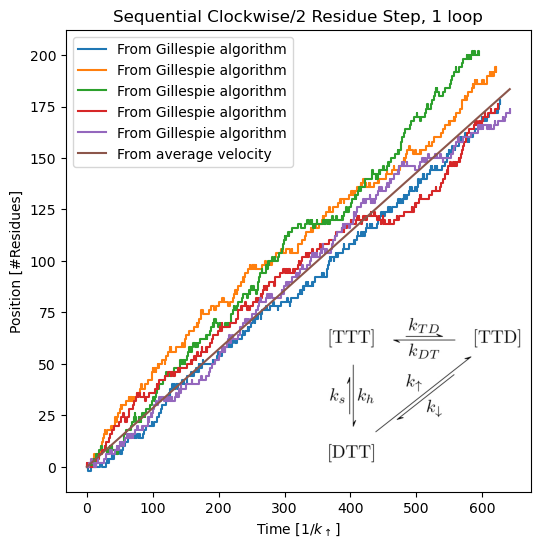

In [35]:
trajectory = SC_2R_1_loop.gillespie(positions=True, n_simulations=5)
fig, ax = SC_2R_1_loop.plot_position_evolution(
    trajectory, 
    r"$1/k_\uparrow$", 
    kinetic_scheme_image_path="SC_2R_1_loop_kinetic_scheme.jpg",
    title="Sequential Clockwise/2 Residue Step, 1 loop")
plt.show()

### 2 different loops

![](SC_2R_2_different_loops_kinetic_scheme.jpg)

In [21]:
# Protomer-ATP/ADP dissociation constants
# Main loop (1)
K_d_ATP_1 = 1
K_d_ADP_1 = 1
# Second loop (2)
K_d_ATP_2 = 1
K_d_ADP_2 = 1

# ATP/ADP ratio concentrations
ATP_over_ADP = 10
ATP_over_ADP_equilibrium = 1

# Transition rates

# Effective ATP/ADP exchange rates
# Main loop
k_DT_1 = 1
# Constraint from ATP-ADP exchange model
k_TD_1 = k_DT_1 * K_d_ATP_1 / K_d_ADP_1 / ATP_over_ADP
# Second loop
k_DT_2 = 0.1
# Constraint from ATP-ADP exchange model
k_TD_2 = k_DT_2 * K_d_ATP_2 / K_d_ADP_2 / ATP_over_ADP

# Move up and down rates
k_up = 1 # Choosen to be the rate of reference for the unit of time
k_down = 0.1

# ATP/ADP hydrolysis/synthesis rates
# Main loop
k_h_1 = 0.1
# Thermodynamic constraint from kinetic scheme
k_s_1 = k_h_1 * k_up * k_DT_1 / (k_down * k_TD_1) * ATP_over_ADP_equilibrium / ATP_over_ADP
# Second loop
k_h_2 = 0.1
# Thermodynamic constraint from kinetic scheme
k_s_2 = k_h_2 * k_up * k_DT_2 / (k_down * k_TD_2) * ATP_over_ADP_equilibrium / ATP_over_ADP

# Probability weights
p_TTT = (k_s_1 * k_DT_1 * (k_DT_2 + k_s_2)
         + k_s_1 * (k_DT_2 * k_down + k_s_2 * k_down + k_DT_2 * k_h_2)
         + k_DT_1 * (k_up * k_s_2 + k_up * k_DT_2 + k_DT_2 * k_s_2))
p_DTT = (k_DT_2 * k_down * k_h_1
         + k_DT_2 * k_down * k_TD_1
         + k_down * k_h_1 * k_s_2
         + k_DT_2 * k_h_1 * (k_h_2 + k_DT_1)
         + k_DT_2 * k_h_2 * k_TD_1
         + k_down * k_s_2 * k_TD_1
         + k_h_1 * k_s_2 * k_DT_1)
p_DTD = (k_h_2 * k_TD_2 * (k_TD_1 + k_h_1)
         + k_h_2 * (k_TD_1 * k_up + k_h_1 * k_up + k_TD_1 * k_s_1)
         + k_TD_2 * (k_down * k_h_1 + k_down * k_TD_1 + k_DT_1 * k_h_1))
p_TTD = (k_TD_1 * k_up * k_s_2
         + k_TD_1 * k_up * k_DT_2
         + k_up * k_s_2 * k_h_1
         + k_TD_1 * k_s_2 * (k_s_1 + k_TD_2)
         + k_TD_1 * k_s_1 * k_DT_2
         + k_up * k_h_1 * k_DT_2
         + k_s_2 * k_h_1 * k_TD_2)
normalization_factor = p_TTT + p_DTT + p_DTD + p_TTD
p_TTT /= normalization_factor
p_DTT /= normalization_factor
p_DTD /= normalization_factor
p_TTD /= normalization_factor

# Model
kinetic_scheme = nx.DiGraph()
kinetic_scheme.add_nodes_from([
    ("TTT", {'probability': p_TTT}),
    ("DTT", {'probability': p_DTT}),
    ("DTD", {'probability': p_DTD}),
    ("TTD", {'probability': p_TTD}),
])
kinetic_scheme.add_edges_from([
    ("TTT", "DTT", {'rate': k_h_1}), ("DTT", "TTT", {'rate': k_s_1}),
    ("DTT", "TTD", {'rate': k_up}), ("TTD", "DTT", {'rate': k_down}),
    ("TTD", "TTT", {'rate': k_DT_1}), ("TTT", "TTD", {'rate': k_TD_1}),
    ("TTD", "DTD", {'rate': k_h_2}), ("DTD", "TTD", {'rate': k_s_2}),
    ("DTD", "DTT", {'rate': k_DT_2}), ("DTT", "DTD", {'rate': k_TD_2})]
)

SC_2R_2_different_loops = TranslocationModel(kinetic_scheme, ("DTT", "TTD"), 2)

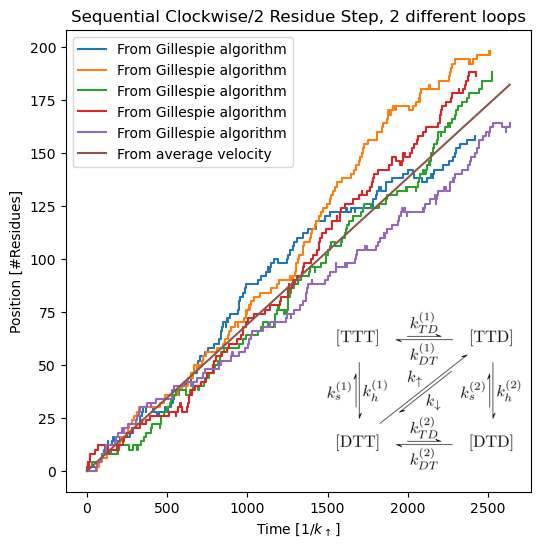

In [23]:
trajectory = SC_2R_2_different_loops.gillespie(positions=True, n_simulations=5)
fig, ax = SC_2R_2_different_loops.plot_position_evolution(
    trajectory, 
    r"$1/k_\uparrow$", 
    kinetic_scheme_image_path="SC_2R_2_different_loops_kinetic_scheme.jpg",
    title="Sequential Clockwise/2 Residue Step, 2 different loops")
plt.show()

### 2 similar loops

[TODO create and add figure]

In [24]:
# ATP/ADP ratio concentrations
ATP_over_ADP = 10
ATP_over_ADP_equilibrium = 1

# Effective ATP/ADP exchange rates
k_DT = 1
# Constraint from ATP-ADP exchange model
k_TD = k_DT * K_d_ATP / K_d_ADP / ATP_over_ADP

# Move up and down rates
k_up = 1 # Choosen to be the rate of reference for the unit of time
# Thermodynamic constraint from kinetic scheme
k_down = k_h * k_up * k_DT / (k_s * k_TD) * ATP_over_ADP_equilibrium / ATP_over_ADP

# Analytical probability of being in each state
p_TTT = (k_s * k_DT * (k_h + k_s + k_up + k_down + k_DT + k_TD)
         + k_up * k_DT**2 + k_s**2 * k_down)
p_DTT = (k_h * k_DT * (k_h + k_s + k_down + k_DT + k_TD)
         + k_down * (k_h * k_s + k_s * k_TD + k_DT * k_TD))
p_DTD = (k_h * k_TD * (k_h + k_s + k_up + k_down + k_DT + k_TD)
         + k_h**2 * k_up + k_down * k_TD**2)
p_TTD = (k_s * k_TD * (k_h + k_s + k_up + k_DT + k_TD)
         + k_up * (k_h * k_s + k_h * k_DT + k_DT * k_TD))
normalization_factor = p_TTT + p_DTT + p_DTD + p_TTD
p_TTT /= normalization_factor
p_DTT /= normalization_factor
p_DTD /= normalization_factor
p_TTD /= normalization_factor

kinetic_scheme = nx.DiGraph()
kinetic_scheme.add_nodes_from([
    ("TTT", {'probability': p_TTT}),
    ("DTT", {'probability': p_DTT}),
    ("DTD", {'probability': p_DTD}),
    ("TTD", {'probability': p_TTD})])
kinetic_scheme.add_edges_from([
    ("TTT", "DTT", {'rate': k_h}), # 1st loop hydrolisis/synthesis
    ("DTT", "TTT", {'rate': k_s}),
    ("DTT", "TTD", {'rate': k_up}), # up/down
    ("TTD", "DTT", {'rate': k_down}),
    ("TTD", "TTT", {'rate': k_DT}), # 1st loop ATP/ADP exchange
    ("TTT", "TTD", {'rate': k_TD}),
    ("DTT", "DTD", {'rate': k_TD}), # 2nd loop ATP/ADP exchange
    ("DTD", "DTT", {'rate': k_DT}),
    ("DTD", "TTD", {'rate': k_s}), # 2nd loop hydrolisis/synthesis
    ("TTD", "DTD", {'rate': k_h})])

SC_2R_2_similar_loops = TranslocationModel(kinetic_scheme, ("DTT", "TTD"), 2)

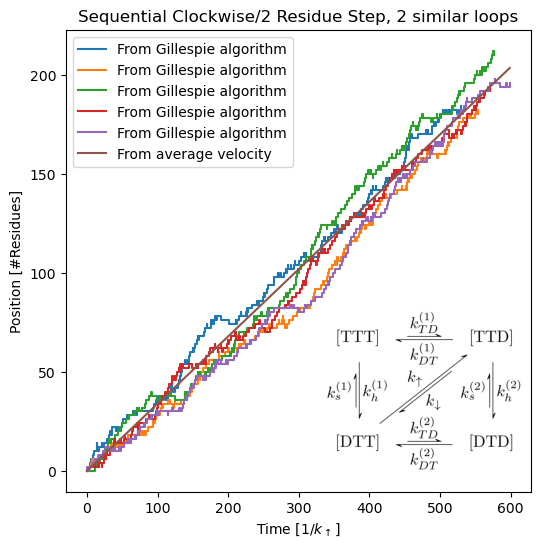

In [25]:
trajectory = SC_2R_2_similar_loops.gillespie(positions=True, n_simulations=5)
fig, ax = SC_2R_2_similar_loops.plot_position_evolution(
    trajectory, 
    r"$1/k_\uparrow$", 
    kinetic_scheme_image_path="SC_2R_2_different_loops_kinetic_scheme.jpg", # TODO create image
    title="Sequential Clockwise/2 Residue Step, 2 similar loops")
plt.show()

## Disc-Spiral model

![](Disc_spiral_kinetic_scheme.jpg)

In [26]:
# TODO find a better name, acronym, and kinetic scheme image

n_protomers = 6

# ATP/ADP ratio concentrations
ATP_over_ADP = 10
ATP_over_ADP_equilibrium = 1

# Effective ATP/ADP exchange rates
k_DT = 1
# Constraint from ATP-ADP exchange model
k_TD = k_DT * K_d_ATP / K_d_ADP / ATP_over_ADP

# ATP/ADP hydrolysis/synthesis rates
k_bar_h = n_protomers * k_h

# Spiral-disc transitions in ATP mode
k_spiral_to_disc_up = 1
k_disc_to_spiral_down = 1

# Disc-spiral transitions in ADP mode
k_disc_to_spiral_up = 1 # Choosen to be the rate of reference for the unit of time
# Thermodynamic constraint from kinetic scheme
k_spiral_to_disc_down = (k_bar_h * k_disc_to_spiral_up * k_DT * k_spiral_to_disc_up
                         / (k_s * k_TD * k_disc_to_spiral_down)
                         * ATP_over_ADP_equilibrium / ATP_over_ADP)

# Analytical probabilites in steady state
p_disc_ATP = (k_s * k_spiral_to_disc_down * k_spiral_to_disc_up
              + k_s * k_DT * k_spiral_to_disc_up
              + k_s * k_spiral_to_disc_down * k_TD
              + k_disc_to_spiral_up * k_DT * k_spiral_to_disc_up)
p_disc_ADP = (k_bar_h * k_spiral_to_disc_down * k_TD
              + k_bar_h * k_spiral_to_disc_down * k_spiral_to_disc_up
              + k_spiral_to_disc_down * k_TD * k_disc_to_spiral_down
              + k_bar_h * k_DT * k_spiral_to_disc_up)
p_spiral_ADP = (k_disc_to_spiral_up * k_TD * k_disc_to_spiral_down
                + k_bar_h * k_disc_to_spiral_up * k_TD
                + k_s * k_TD * k_disc_to_spiral_down
                + k_bar_h * k_disc_to_spiral_up * k_spiral_to_disc_up)
p_spiral_ATP = (k_s * k_DT * k_disc_to_spiral_down
                + k_disc_to_spiral_up * k_DT * k_disc_to_spiral_down
                + k_s * k_spiral_to_disc_down * k_disc_to_spiral_down
                + k_bar_h * k_disc_to_spiral_up * k_DT)
normalization_factor = p_disc_ATP + p_disc_ADP + p_spiral_ADP + p_spiral_ATP
p_disc_ATP /= normalization_factor
p_disc_ADP /= normalization_factor
p_spiral_ADP /= normalization_factor
p_spiral_ATP /= normalization_factor

kinetic_scheme = nx.DiGraph()
kinetic_scheme.add_nodes_from([
    ("━━", {'probability': p_disc_ATP}),
    ("┉┉", {'probability': p_disc_ADP}),
    ("┋", {'probability': p_spiral_ADP}),
    ("┃", {'probability': p_spiral_ATP})])
kinetic_scheme.add_edges_from([
    ("━━", "┉┉", {'rate': k_bar_h}), 
    ("┉┉", "━━", {'rate': k_s}),
    ("┉┉", "┋", {'rate': k_disc_to_spiral_up}), 
    ("┋", "┉┉", {'rate': k_spiral_to_disc_down}),
    ("┋", "┃", {'rate': k_DT}), 
    ("┃", "┋", {'rate': k_TD}),
    ("┃", "━━", {'rate': k_spiral_to_disc_up}), 
    ("━━", "┃", {'rate': k_disc_to_spiral_down})]
)

disc_spiral = TranslocationModel(kinetic_scheme, ("┉┉", "┋"), 
                               n_residues_per_step=2*(n_protomers-1), 
                               n_protomers=n_protomers)

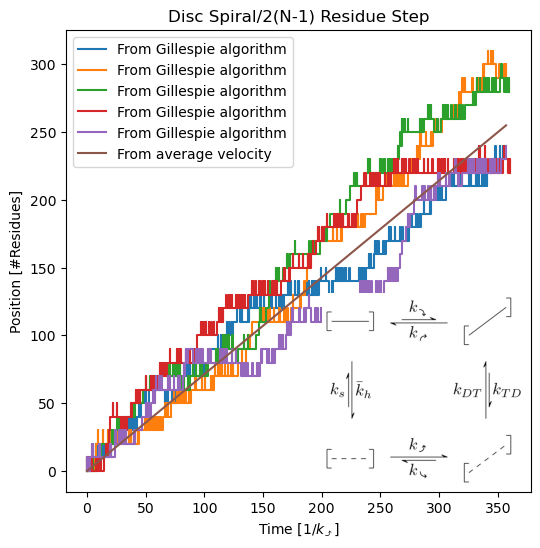

In [28]:
trajectory = disc_spiral.gillespie(positions=True, n_simulations=5)
fig, ax = disc_spiral.plot_position_evolution(
    trajectory, 
    r"$1/k_⤴$", 
    kinetic_scheme_image_path="Disc_spiral_kinetic_scheme.jpg",
    title="Disc Spiral/2(N-1) Residue Step")
plt.show()

# Experiments

## 